# auto feature nyc taxi +  training

## pipeline:

1. RecDP will automtaiclly defer (schema_infer) each columns' type, will do try_decode. 
2. Then RecDP will do data clean (data profiler) 
    * i.e., fillNA, currently we can handle default for datetime, string, numerica -int, float. 
    * i.e., missing value impute 
3. Then RecDp will do feature engineering automatically (feature wrangler) 
    * call different primtives based on data type
    * i.e., decode text tokens 
    * We will use AutoFE to generate new additional features 
    * date time -> week of year, month, .... 
    * text -> count unique value
4. Drop features - get data ready for train 
    * drop duplicated features 
    * transfomer features which not ready for training -> categorify 

## 1. Load Datasets

In [1]:
import pandas as pd
train_data = pd.read_csv(f"/home/vmagent/app/recdp/dataset/nyc_taxi_fare/nyc_taxi_fare_cleaned_train.csv")
print("original input is ")
display(train_data)
train_data.dtypes

original input is 


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
51600152,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
51600153,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
51600154,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
51600155,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## 2. Generate pipeline for training

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


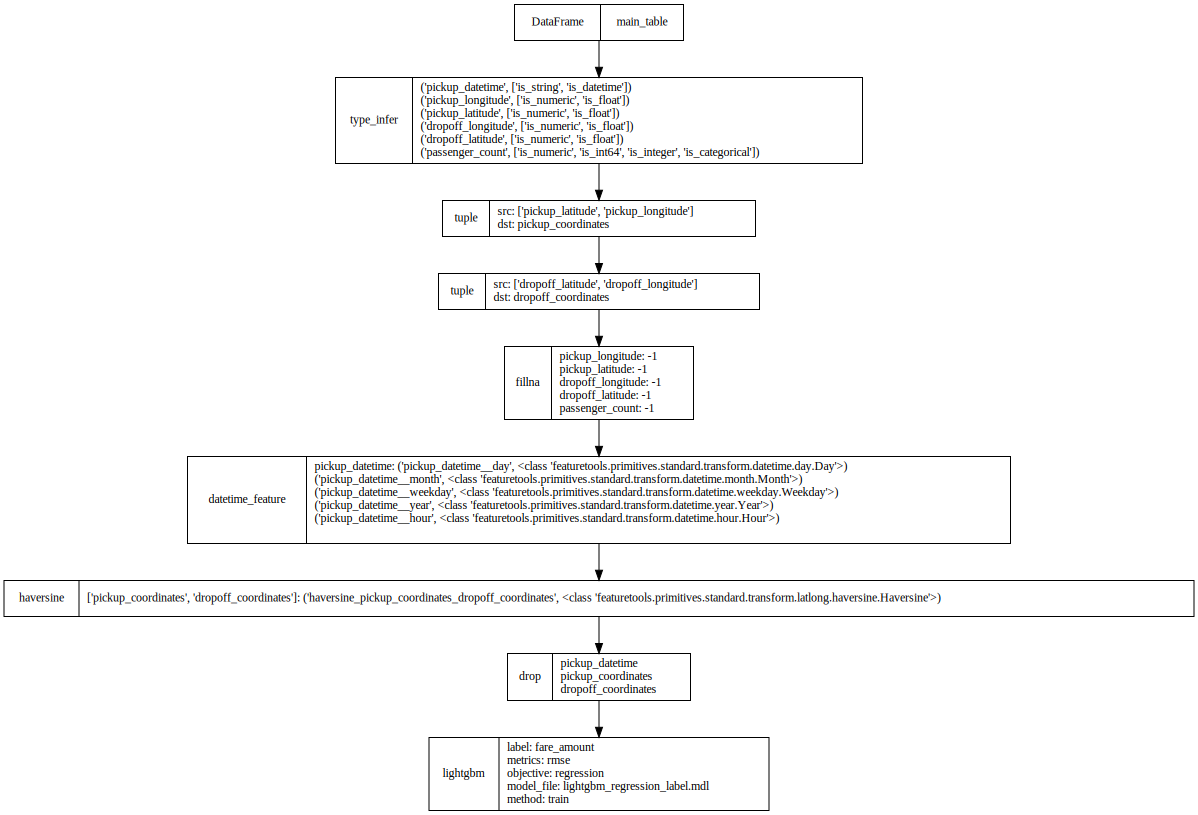

In [2]:
from pyrecdp.autofe import FeatureWrangler, DataEstimator
from pyrecdp.autofe import DataEstimator

data_pipeline = FeatureWrangler(dataset=train_data, label="fare_amount")
pipeline = DataEstimator(metrics = 'rmse', model_name='lightgbm', method = 'train', data_pipeline = data_pipeline)
pipeline.plot()

## 3. execute pipeline with spark

In [3]:
transformed_data = pipeline.fit_transform('spark')
display(transformed_data)

Will assign 48 cores and 308513 M memory for spark
23/03/10 03:18:45 WARN Utils: Your hostname, sr419 resolves to a loopback address: 127.0.1.1; using 10.0.2.19 instead (on interface ens818f1)
23/03/10 03:18:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/10 03:18:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
per core memory size is 6.277 GB and shuffle_disk maximum capacity is 8589934592.000 GB
append DataFrame
append type_infer
append DataFrameToRDDConverter
DataframeConvert partition pandas dataframe to spark RDD took 26.884 secs
append tuple
append tuple
append fillna
append datetime_feature
append haversine
append drop
append lightgbm
append RDDToDataFrameConverter
23/03/10 03:19:15 WARN TaskSetManager: Stage 0 contains a task of very large size (82191 KiB). The maximum recommended task size is 1000 KiB.


DataframeTransform took 87.103 secs, processed 51600157 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 2.389 secs


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_w

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.776365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25091
[LightGBM] [Info] Number of data points in the train set: 49020149, number of used features: 11


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.323876
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.95403
[200]	valid_0's rmse: 3.8361
[300]	valid_0's rmse: 3.77504
[400]	valid_0's rmse: 3.73946
[500]	valid_0's rmse: 3.70909
[600]	valid_0's rmse: 3.68656
[700]	valid_0's rmse: 3.66972
[800]	valid_0's rmse: 3.65549
[900]	valid_0's rmse: 3.64516
[1000]	valid_0's rmse: 3.63246
[1100]	valid_0's rmse: 3.62255
[1200]	valid_0's rmse: 3.6155
[1300]	valid_0's rmse: 3.60656
[1400]	valid_0's rmse: 3.59831
[1500]	valid_0's rmse: 3.59089
[1600]	valid_0's rmse: 3.58407
[1700]	valid_0's rmse: 3.57755
[1800]	valid_0's rmse: 3.57248
[1900]	valid_0's rmse: 3.56712
[2000]	valid_0's rmse: 3.56388
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 3.56388


# 4. export pipeline to JSON

In [5]:
pipeline.export()

{
    "0": {
        "children": null,
        "op": "DataFrame",
        "config": "'main_table'"
    },
    "1": {
        "children": [
            0
        ],
        "op": "type_infer",
        "config": [
            "('pickup_datetime', ['is_string', 'is_datetime'])",
            "('pickup_longitude', ['is_numeric', 'is_float'])",
            "('pickup_latitude', ['is_numeric', 'is_float'])",
            "('dropoff_longitude', ['is_numeric', 'is_float'])",
            "('dropoff_latitude', ['is_numeric', 'is_float'])",
            "('passenger_count', ['is_numeric', 'is_int64', 'is_integer', 'is_categorical'])"
        ]
    },
    "2": {
        "children": [
            1
        ],
        "op": "tuple",
        "config": {
            "src": [
                "'pickup_latitude'",
                "'pickup_longitude'"
            ],
            "dst": "'pickup_coordinates'"
        }
    },
    "3": {
        "children": [
            2
        ],
        "op": "tuple",
     

## Optional - process with pandas

In [3]:
pipeline.fit_transform('pandas')

Will assign 48 cores and 308513 M memory for spark
23/03/06 09:25:18 WARN Utils: Your hostname, sr419 resolves to a loopback address: 127.0.1.1; using 10.0.2.19 instead (on interface ens818f1)
23/03/06 09:25:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/06 09:25:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
per core memory size is 6.277 GB and shuffle_disk maximum capacity is 8589934592.000 GB
append DataFrame
append type_infer
append DataFrameToRDDConverter
DataframeConvert partition pandas dataframe to spark RDD took 0.320 secs
append tuple
append tuple
append fillna
append datetime_feature
append haversine
append drop
append RDDToDataFrameConverter
execute with spark started ...


DataframeTransform took 5.644 secs, processed 10000 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 0.015 secs
execute with spark took 5.6608173889108 sec


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime__day,pickup_datetime__month,pickup_datetime__weekday,pickup_datetime__year,pickup_datetime__hour,haversine_pickup_coordinates_dropoff_coordinates
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,6,0,2009,17,0.640488
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,1,1,2010,16,5.250677
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,8,3,2011,0,0.863412
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,5,2012,4,1.739388
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,3,1,2010,7,1.242220
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,16.9,-73.994594,40.732393,-73.974557,40.788259,1,30,1,5,2010,22,3.999877
9996,5.5,-74.001017,40.746352,-73.990873,40.739497,1,23,1,3,2014,18,0.711558
9997,4.5,-74.005530,40.720826,-73.996565,40.716309,1,5,5,3,2011,19,0.563746
9998,8.0,-74.001850,40.745591,-74.006125,40.723338,1,4,8,6,2013,11,1.553741
